In [1]:
import os
import tensorflow as tf

from tensorflow import keras

from functions.plotting import plot_single_output_history
from image_manipulation.layers.featurewise_std_normalization import FeaturewiseStdNormalization
from image_manipulation.layers.featurewise_center import FeaturewiseCenter
from image_manipulation.layers.samplewise_center import SamplewiseCenter
SMALLER_HEIGHT = 75
SMALLER_WIDTH = 100

In [2]:
base_data_dir = os.path.join(
    '..',
    '..',
    'data_100x75_categorized_no_nv')
train_data_dir = os.path.join(base_data_dir, 'training')
valid_data_dir = os.path.join(base_data_dir, 'validation')
test_data_dir = os.path.join(base_data_dir, 'test')

train_ds = keras.utils.image_dataset_from_directory(
    directory=train_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(SMALLER_HEIGHT, SMALLER_WIDTH))
valid_ds = keras.utils.image_dataset_from_directory(
    directory=valid_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(SMALLER_HEIGHT, SMALLER_WIDTH))

Found 9855 files belonging to 9 classes.
Found 2458 files belonging to 9 classes.


In [3]:
feature_centering_train = FeaturewiseCenter()
feature_centering_valid = FeaturewiseCenter()
feature_normalization_train = FeaturewiseStdNormalization()
feature_normalization_valid = FeaturewiseStdNormalization()
samplewise_centering_train = SamplewiseCenter()
samplewise_std_train = SamplewiseCenter()
samplewise_centering_valid = SamplewiseCenter()
samplewise_std_valid = SamplewiseCenter()

feature_centering_train.adapt(train_ds)
feature_centering_valid.adapt(valid_ds)
feature_normalization_train.adapt(train_ds)
feature_normalization_valid.adapt(valid_ds)

data_augmentation_train = keras.Sequential([
    feature_centering_train,
    feature_normalization_train,
    # samplewise_centering_train,
    # samplewise_std_train,
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(.9),
    keras.layers.RandomBrightness((-.3, .3)),
    keras.layers.RandomZoom((.3, -.3), (.3, -.3))
])
data_augmentation_valid = keras.Sequential([
    feature_centering_valid,
    feature_normalization_valid,
    # samplewise_centering_valid,
    # samplewise_std_valid
])
train_ds = train_ds\
    .cache()\
    .shuffle(1000)\
    .map(lambda x, y: (data_augmentation_train(x), y))\
    .prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds\
    .cache()\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [4]:
num_classes = 9


def get_simplest_model(
        multiply_first: int = 1,
        multiply_second: int = 1,
        multiply_third: int = 1) -> keras.Model:
    def get_conv_module(units: int, kernel_size: int, strides: int) -> list[keras.layers.Layer]:
        yield keras.layers.Conv2D(units, kernel_size, padding='same', strides=strides)
        yield keras.layers.BatchNormalization()
        yield keras.layers.PReLU()
        yield keras.layers.Conv2D(units, kernel_size, padding='same')
        yield keras.layers.BatchNormalization()
        yield keras.layers.PReLU()
        yield keras.layers.MaxPooling2D()

    units_and_strides = [
        (128 * multiply_first, 5, 1),
        (128 * multiply_first, 5, 1),
        (256 * multiply_second, 5, 1),
        (512 * multiply_third, 3, 1)]
    model = keras.Sequential()

    model.add(keras.layers.Rescaling(1./255, input_shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3)))

    for units, kernel_size, strides in units_and_strides:
        for layer in get_conv_module(units, kernel_size, strides):
            model.add(layer)

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [5]:
model = get_simplest_model()

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 75, 100, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 75, 100, 128)      9728      
                                                                 
 batch_normalization (BatchN  (None, 75, 100, 128)     512       
 ormalization)                                                   
                                                                 
 p_re_lu (PReLU)             (None, 75, 100, 128)      960000    
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 128)      409728    
                                                                 
 batch_normalization_1 (Batc  (None, 75, 100, 128)     512       
 hNormalization)                                      

In [6]:
history1 = model.fit(train_ds, validation_data=valid_ds, epochs=30)

Epoch 1/30
308/308 [==============================] - 102s 285ms/step - loss: 1.5746 - accuracy: 0.5395 - val_loss: 2.1014 - val_accuracy: 0.5745
Epoch 2/30
308/308 [==============================] - 80s 260ms/step - loss: 1.4719 - accuracy: 0.5609 - val_loss: 3.6548 - val_accuracy: 0.5342
Epoch 3/30
308/308 [==============================] - 80s 261ms/step - loss: 1.4648 - accuracy: 0.5608 - val_loss: 6.0766 - val_accuracy: 0.4764
Epoch 4/30
308/308 [==============================] - 80s 261ms/step - loss: 1.4543 - accuracy: 0.5652 - val_loss: 6.2316 - val_accuracy: 0.5443
Epoch 5/30
308/308 [==============================] - 80s 259ms/step - loss: 1.4470 - accuracy: 0.5652 - val_loss: 11.9161 - val_accuracy: 0.1778
Epoch 6/30
308/308 [==============================] - 79s 257ms/step - loss: 1.4324 - accuracy: 0.5689 - val_loss: 10.3134 - val_accuracy: 0.2608
Epoch 7/30
308/308 [==============================] - 79s 257ms/step - loss: 1.4218 - accuracy: 0.5671 - val_loss: 14.8119 - va

KeyboardInterrupt: 

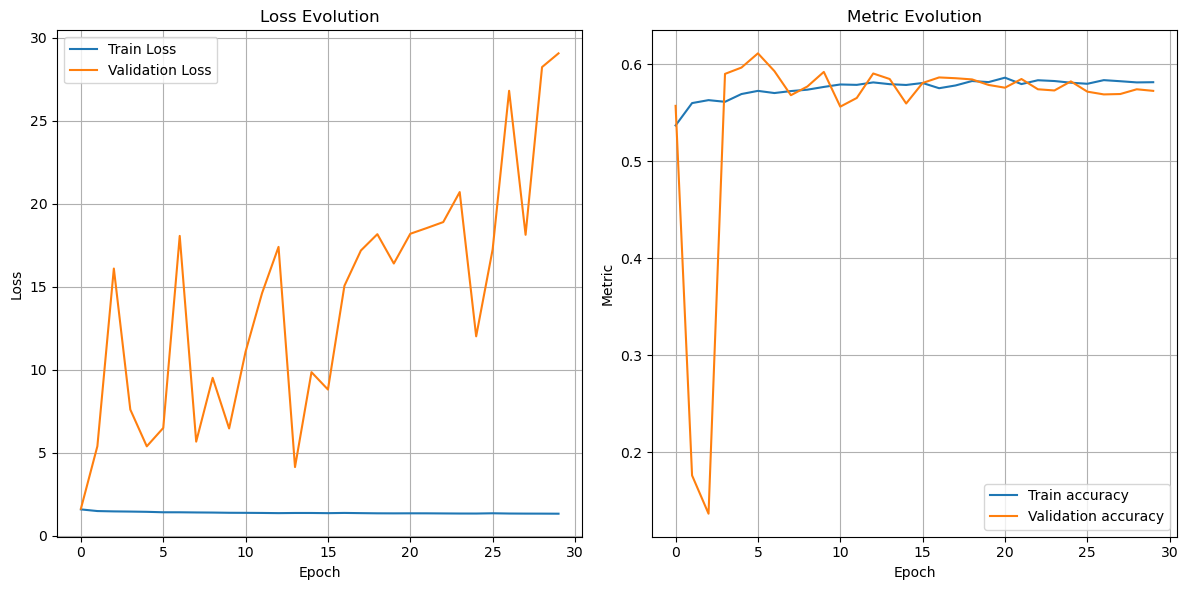

In [7]:
plot_single_output_history(history1)

In [8]:
model = get_simplest_model(2)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 75, 100, 3)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 50, 64)        1792      
                                                                 
 batch_normalization_6 (Batc  (None, 38, 50, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 50, 64)        36928     
                                                                 
 batch_normalization_7 (Batc  (None, 38, 50, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 25, 64)      

In [ ]:
history2 = model.fit(train_ds, validation_data=valid_ds, epochs=50)

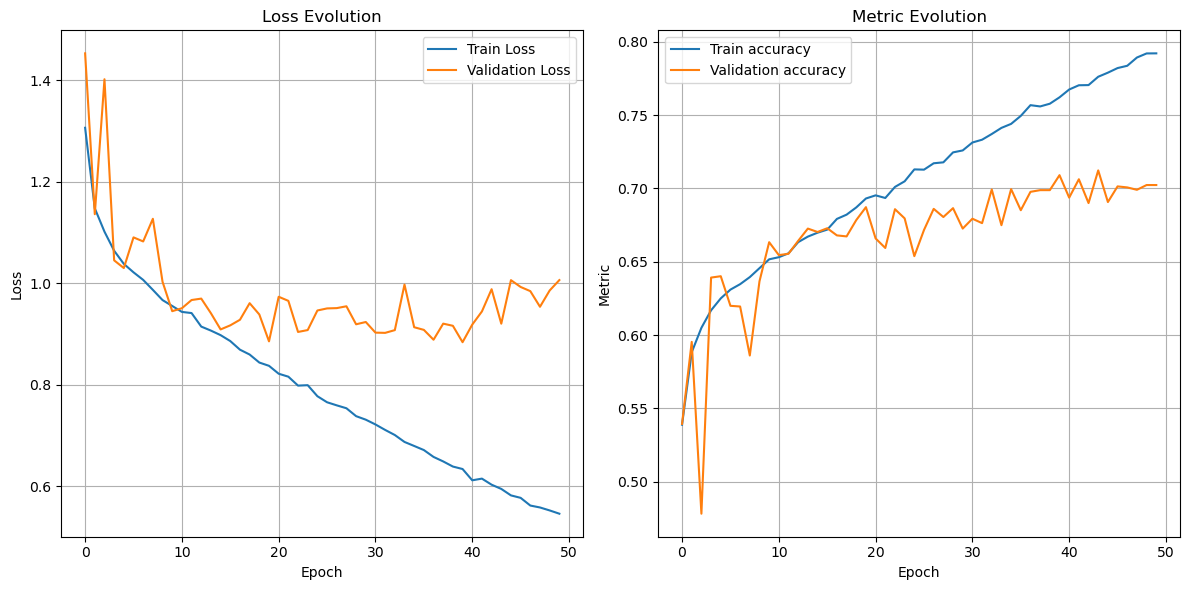

In [10]:
plot_single_output_history(history2)

In [11]:
model = get_simplest_model(2, 2)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 75, 100, 3)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 38, 50, 64)        1792      
                                                                 
 batch_normalization_12 (Bat  (None, 38, 50, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 38, 50, 64)        36928     
                                                                 
 batch_normalization_13 (Bat  (None, 38, 50, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 19, 25, 64)      

In [12]:
history3 = model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50
539/539 [==============================] - 18s 31ms/step - loss: 1.3353 - accuracy: 0.5316 - val_loss: 1.2778 - val_accuracy: 0.5575
Epoch 2/50
539/539 [==============================] - 17s 31ms/step - loss: 1.1591 - accuracy: 0.5832 - val_loss: 1.2440 - val_accuracy: 0.5547
Epoch 3/50
539/539 [==============================] - 16s 31ms/step - loss: 1.1075 - accuracy: 0.6044 - val_loss: 1.1015 - val_accuracy: 0.6069
Epoch 4/50
539/539 [==============================] - 16s 30ms/step - loss: 1.0761 - accuracy: 0.6133 - val_loss: 1.0967 - val_accuracy: 0.5976
Epoch 5/50
539/539 [==============================] - 17s 31ms/step - loss: 1.0508 - accuracy: 0.6201 - val_loss: 1.0973 - val_accuracy: 0.6348
Epoch 6/50
539/539 [==============================] - 16s 31ms/step - loss: 1.0283 - accuracy: 0.6295 - val_loss: 1.1189 - val_accuracy: 0.5916
Epoch 7/50
539/539 [==============================] - 17s 31ms/step - loss: 1.0146 - accuracy: 0.6272 - val_loss: 1.0184 - val_accuracy:

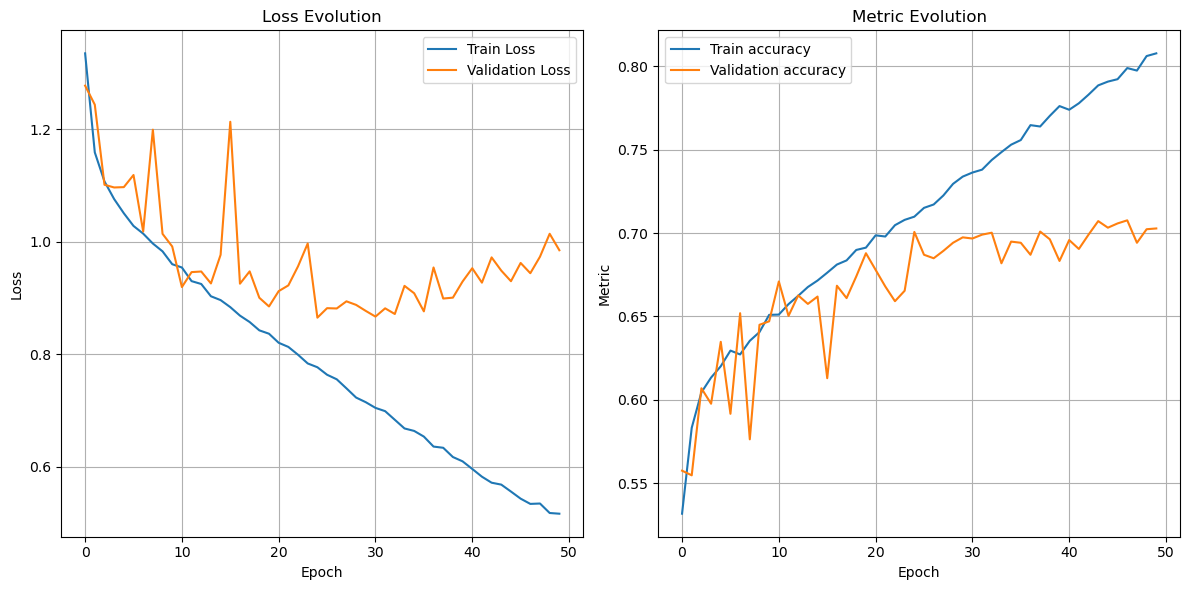

In [13]:
plot_single_output_history(history3)

In [14]:
model = get_simplest_model(2, 2, 3)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 75, 100, 3)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 38, 50, 64)        1792      
                                                                 
 batch_normalization_18 (Bat  (None, 38, 50, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 38, 50, 64)        36928     
                                                                 
 batch_normalization_19 (Bat  (None, 38, 50, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 19, 25, 64)      

In [15]:
history4 = model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50
539/539 [==============================] - 21s 36ms/step - loss: 1.5191 - accuracy: 0.5059 - val_loss: 1.2776 - val_accuracy: 0.5596
Epoch 2/50
539/539 [==============================] - 19s 35ms/step - loss: 1.2037 - accuracy: 0.5689 - val_loss: 1.1790 - val_accuracy: 0.5881
Epoch 3/50
539/539 [==============================] - 19s 35ms/step - loss: 1.1479 - accuracy: 0.5909 - val_loss: 1.4409 - val_accuracy: 0.5605
Epoch 4/50
539/539 [==============================] - 19s 35ms/step - loss: 1.1074 - accuracy: 0.6052 - val_loss: 1.1964 - val_accuracy: 0.5967
Epoch 5/50
539/539 [==============================] - 19s 35ms/step - loss: 1.0837 - accuracy: 0.6132 - val_loss: 1.1073 - val_accuracy: 0.6067
Epoch 6/50
539/539 [==============================] - 19s 35ms/step - loss: 1.0579 - accuracy: 0.6180 - val_loss: 1.0788 - val_accuracy: 0.6227
Epoch 7/50
539/539 [==============================] - 19s 35ms/step - loss: 1.0405 - accuracy: 0.6256 - val_loss: 1.2013 - val_accuracy:

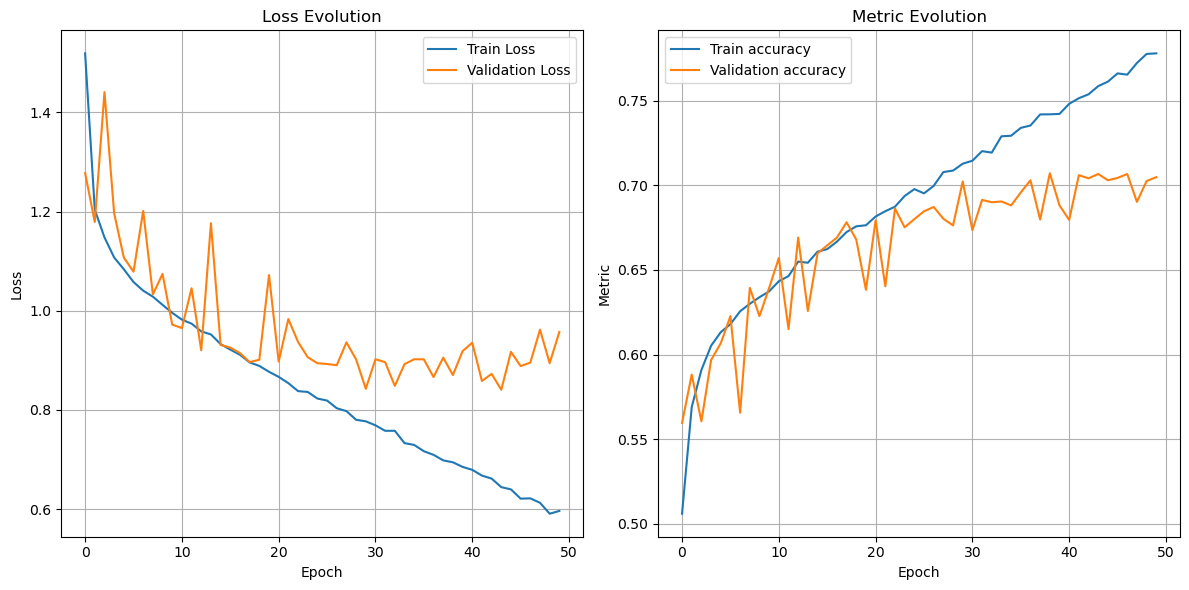

In [16]:
plot_single_output_history(history4)

In [17]:
def get_bigger_model(
        multiply_first: int = 1,
        multiply_second: int = 1,
        multiply_third: int = 1) -> keras.Model:
    def get_conv_module(units: int) -> list[keras.layers.Layer]:
        yield keras.layers.Conv2D(units, 5, activation='relu', padding='same', strides=strides)
        yield keras.layers.BatchNormalization()
        yield keras.layers.Conv2D(units, 5, activation='relu', padding='same')
        yield keras.layers.BatchNormalization()
        yield keras.layers.MaxPooling2D()

    units_and_strides = [
        (64 * multiply_first, 2),
        (128 * multiply_second, 1),
        (256 * multiply_third, 1)]
    model = keras.Sequential()

    model.add(keras.layers.Rescaling(1./255, input_shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3)))

    for units, strides in units_and_strides:
        for layer in get_conv_module(units):
            model.add(layer)

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [18]:
model = get_bigger_model(2, 2, 3)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 75, 100, 3)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 38, 50, 128)       9728      
                                                                 
 batch_normalization_24 (Bat  (None, 38, 50, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 38, 50, 128)       409728    
                                                                 
 batch_normalization_25 (Bat  (None, 38, 50, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 19, 25, 128)     

In [19]:
history5 = model.fit(train_ds, validation_data=valid_ds, epochs=40)

Epoch 1/40
539/539 [==============================] - 65s 109ms/step - loss: 1.9342 - accuracy: 0.4671 - val_loss: 1.3865 - val_accuracy: 0.4920
Epoch 2/40
539/539 [==============================] - 56s 103ms/step - loss: 1.2848 - accuracy: 0.5355 - val_loss: 1.1853 - val_accuracy: 0.5818
Epoch 3/40
539/539 [==============================] - 56s 103ms/step - loss: 1.2095 - accuracy: 0.5653 - val_loss: 1.1142 - val_accuracy: 0.6025
Epoch 4/40
539/539 [==============================] - 56s 103ms/step - loss: 1.1706 - accuracy: 0.5819 - val_loss: 1.1779 - val_accuracy: 0.5879
Epoch 5/40
539/539 [==============================] - 56s 103ms/step - loss: 1.1332 - accuracy: 0.5984 - val_loss: 1.2470 - val_accuracy: 0.6085
Epoch 6/40
539/539 [==============================] - 56s 103ms/step - loss: 1.1224 - accuracy: 0.6024 - val_loss: 1.1153 - val_accuracy: 0.6174
Epoch 7/40
539/539 [==============================] - 56s 103ms/step - loss: 1.0935 - accuracy: 0.6122 - val_loss: 1.0343 - val_ac

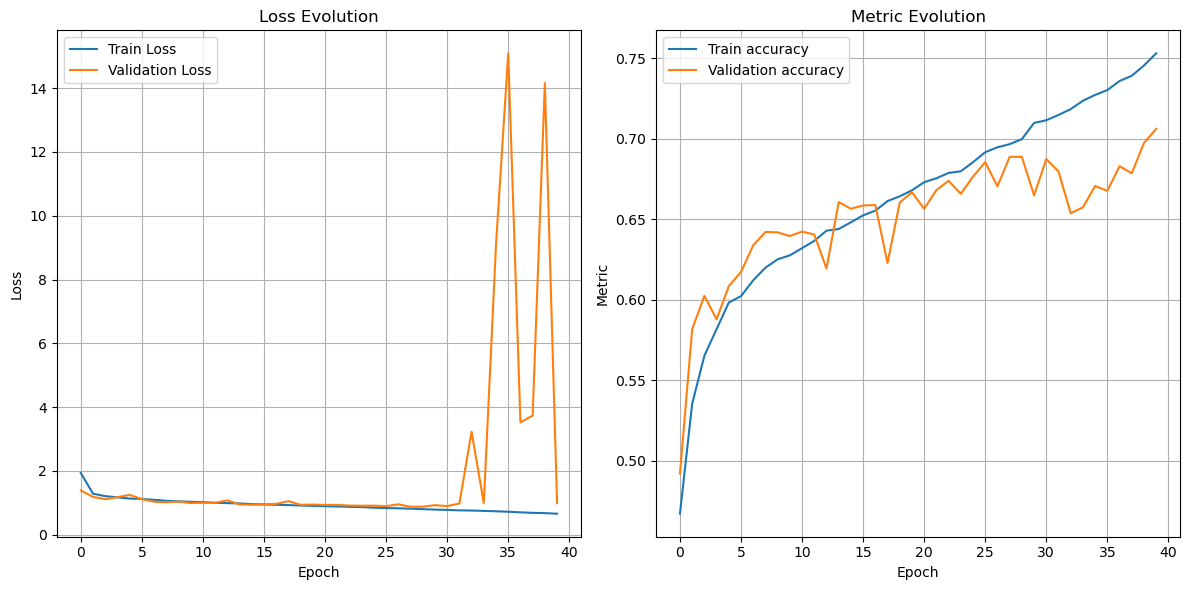

In [20]:
plot_single_output_history(history5)